# 01 - ComCam x Milliquas
**Author:** Olivia Lynn  
**Last Run:** March 27, 2025

*Part of the [AGN Variability project from March 2025](https://docs.google.com/document/d/1yb43z7vrG5-FIL6lNZjVkIx41jKSCl698d51RQhXRqg/edit?tab=t.0)*

## Set up
Imports and dask

In [1]:
import lsdb
print(lsdb.__version__)
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from dask.distributed import Client
from nested_pandas import NestedDtype

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.


0.5.3.dev6+gfc62489


In [15]:
import hats
print(hats.__version__)

0.5.3.dev2+g9f35663


In [2]:
client = Client(n_workers=4, memory_limit="auto")
client

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.diskutils:Found stale lock file and directory '/lscratch/ncaplar/dask-scratch-space/scheduler-y45mfigf', purging
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:23479
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:27415'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:5023'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:5097'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:5715'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:14765 name: 3
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:14765
INFO:distributed.core:Starting estab

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 120,Total memory: 511.92 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:23479,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:11299,Total threads: 30
Dashboard: http://127.0.0.1:12123/status,Memory: 127.98 GiB
Nanny: tcp://127.0.0.1:27415,


## Get catalogs
ComCam and MilliQuas

In [3]:
comcam_cat = lsdb.read_hats('/sdf/data/rubin/shared/lsdb_commissioning/hats/v29_0_0_rc5/dia_object_lc',
                            margin_cache='/sdf/data/rubin/shared/lsdb_commissioning/hats/v29_0_0_rc5/dia_object_lc_5arcs')

In [4]:
# This cell from: https://github.com/lsst-sitcom/linccf/blob/main/demo_notebooks/periodic_lightcurves.ipynb

def cast_nested(df, columns):
    return df.assign(
        **{
            col: df[col].astype(NestedDtype.from_pandas_arrow_dtype(df.dtypes[col]))
            for col in columns
        },
    )

comcam_cat = comcam_cat.map_partitions(
    cast_nested, columns=["diaSource", "diaObjectForcedSource"]
)

In [5]:
miliquas_cat = lsdb.read_hats(
    "/sdf/data/rubin/user/olynn/AGNs/hats/Milliquas_v8",
    margin_cache="/sdf/data/rubin/u/olynn/AGNs/hats/Milliquas_v8_margin/Milliquas_v8_10arcs",
)

## Do crossmatch
ComCam x MilliQuas

In [7]:
miliquas_cat.hc_structure.original_schema

_healpix_29: int64
RA: double
DEC: double
NAME: string
TYPE: string
RMAG: float
BMAG: float
COMMENT: string
R: string
B: string
Z: float
CITE: string
ZCITE: string
XNAME: string
RNAME: string
LOBE1: string
LOBE2: string

In [11]:
comcam_x_milliquas.hc_structure.original_schema

In [27]:
comcam_x_milliquas = comcam_cat.crossmatch(miliquas_cat, suffixes=["_COM", "_MIL"], radius_arcsec=.3)
# comcam_x_milliquas

In [28]:
comcam_x_milliquas

ValueError: Original Catalog Columns are not available

Dask NestedFrame Structure:
                    diaObjectId_COM           ra_COM          dec_COM nDiaSources_COM  radecMjdTai_COM       tract_COM                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

## Verify crossmatch

/sdf/home/n/ncaplar/.local/lib/python3.12/site-packages/hats/inspection/visualize_catalog.py:317: UserWarning: This plot contains HEALPix pixels smaller than a pixel of the plot. Some values may be lost
  warnings.warn(


(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'COMCAM x Milliquas'}>)

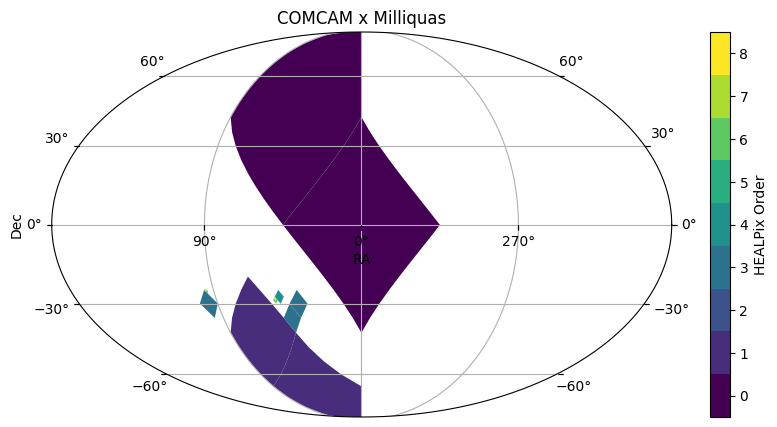

In [29]:
comcam_x_milliquas.plot_pixels(plot_title="COMCAM x Milliquas")

In [72]:
comcam_x_milliquas_computed = comcam_x_milliquas.compute()

In [34]:
len(comcam_x_milliquas_computed)

177

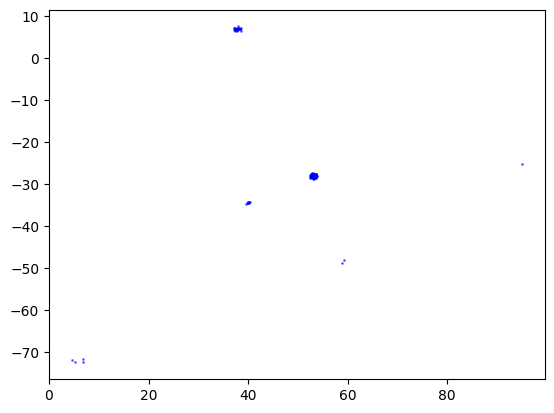

In [36]:
plt.scatter(comcam_x_milliquas_computed[['ra_COM']], 
            comcam_x_milliquas_computed[['dec_COM']],
            s=1,
            c='blue',
            alpha=0.5,
            label='COMCAM',
            marker='o'
           )

In [49]:
comcam_x_milliquas_computed["diaObjectForcedSource_COM"]

_healpix_29
9583286184991586       [{parentObjectId: 0, coord_ra: 37.78485, coord...
9589207111731798       [{parentObjectId: 0, coord_ra: 38.493226, coor...
                                             ...                        
2531133149718993894    [{parentObjectId: 0, coord_ra: 39.903773, coor...
2531133272813443525    [{parentObjectId: 0, coord_ra: 39.954222, coor...
Name: diaObjectForcedSource_COM, Length: 177, dtype: nested<parentObjectId: [int64], coord_ra: [double], coord_dec: [double], visit: [int64], detector: [int16], band: [string], psfFlux: [float], psfFluxErr: [float], psfFlux_flag: [bool], psfDiffFlux: [float], psfDiffFluxErr: [float], psfDiffFlux_flag: [bool], diff_PixelFlags_nodataCenter: [bool], pixelFlags_bad: [bool], pixelFlags_cr: [bool], pixelFlags_crCenter: [bool], pixelFlags_edge: [bool], pixelFlags_interpolated: [bool], pixelFlags_interpolatedCenter: [bool], pixelFlags_nodata: [bool], pixelFlags_saturated: [bool], pixelFlags_saturatedCenter: [bool], pixelFla

In [46]:
comcam_x_milliquas_computed["n_sources"] = comcam_x_milliquas_computed["diaObjectForcedSource_COM"].apply(len)

In [83]:
bands = ["u", "g", "r", "i", "z", "y"]

def count_bands(entry):
    result = {}
    for band in bands:
        try:
            result[band] = (entry['band'] == band).sum()
        except Exception:
            result[band] = 0
    return result


# Apply to each row
band_counts = comcam_x_milliquas_computed["diaObjectForcedSource_COM"].apply(count_bands)
print(band_counts)
# Turn into a proper DataFrame
band_counts_df = pd.DataFrame(band_counts.tolist()).fillna(0).astype(int)

# Add to original
for band in bands:
    comcam_x_milliquas_computed[f"n_{band}"] = band_counts_df[band].values

_healpix_29
9583286184991586       {'u': 0, 'g': 12, 'r': 10, 'i': 13, 'z': 4, 'y...
9589207111731798        {'u': 0, 'g': 3, 'r': 4, 'i': 6, 'z': 4, 'y': 0}
                                             ...                        
2531133149718993894    {'u': 0, 'g': 4, 'r': 24, 'i': 10, 'z': 0, 'y'...
2531133272813443525    {'u': 0, 'g': 4, 'r': 23, 'i': 11, 'z': 0, 'y'...
Name: diaObjectForcedSource_COM, Length: 177, dtype: object


In [84]:
comcam_x_milliquas_computed

diaObjectId_COM     ra_COM    dec_COM  \
_healpix_29                                                      
9583286184991586     4601816802056470555   37.78485   6.401707   
9589207111731798     4602278596940136493  38.493226   6.427911   
...                                  ...        ...        ...   
2531133149718993894  1766616118673277889  39.903773 -34.358387   
2531133272813443525  1766616118673278246  39.954222 -34.333328   

                     nDiaSources_COM  radecMjdTai_COM  tract_COM  \
_healpix_29                                                        
9583286184991586                   9     60643.083293      10463   
9589207111731798                   2     60638.131253      10464   
...                              ...              ...        ...   
2531133149718993894                6     60650.179955       4016   
2531133272813443525                1     60639.270055       4016   

                                                         diaSource_COM  \
_healpix_29                                                              
9583286184991586     [{visit: 2024112300214, detector: 8, band: 'r'...   
9589207111731798     [{visit: 2024112300221, detector: 5, band: 'r'...   
...                                                                ...   
2531133149718993894  [{visit: 2024112400239, detector: 4, band: 'r'...   
2531133272813443525  [{visit: 2024112400274, detector: 4, band: 'i'...   

                                             diaObjectForcedSource_COM  \
_healpix_29                                                              
9583286184991586     [{parentObjectId: 0, coord_ra: 37.78485, coord...   
9589207111731798     [{parentObjectId: 0, coord_ra: 38.493226, coor...   
...                                                                ...   
2531133149718993894  [{parentObjectId: 0, coord_ra: 39.903773, coor...   
2531133272813443525  [{parentObjectId: 0, coord_ra: 39.954222, coor...   

                        RA_MIL    DEC_MIL  ...               RNAME_MIL  \
_healpix_29                                ...                           
9583286184991586     37.784846   6.401708  ...                           
9589207111731798     38.493228    6.42792  ...  VLAJ023358.35+062540.6   
...                        ...        ...  ...                     ...   
2531133149718993894  39.903809 -34.358342  ...                           
2531133272813443525  39.954219 -34.333329  ...                           

                                  LOBE1_MIL               LOBE2_MIL  \
_healpix_29                                                           
9583286184991586                                                      
9589207111731798     FIRST J023358.3+062540  RACS J023358.4+062541    
...                                     ...                     ...   
2531133149718993894                                                   
2531133272813443525                                                   

                     _dist_arcsec n_u n_g n_r  n_i n_z n_y  
_healpix_29                                                 
9583286184991586         0.013628   0  12  10   13   4   0  
9589207111731798         0.033737   0   3   4    6   4   0  
...                           ...  ..  ..  ..  ...  ..  ..  
2531133149718993894      0.191274   0   4  24   10   0   0  
2531133272813443525      0.011135   0   4  23   11   0   0  

[177 rows x 31 columns]

(array([69., 14.,  8., 13.,  6., 14., 11., 12.,  9., 21.]),
 array([  0. ,  15.4,  30.8,  46.2,  61.6,  77. ,  92.4, 107.8, 123.2,
        138.6, 154. ]),
 <BarContainer object of 10 artists>)

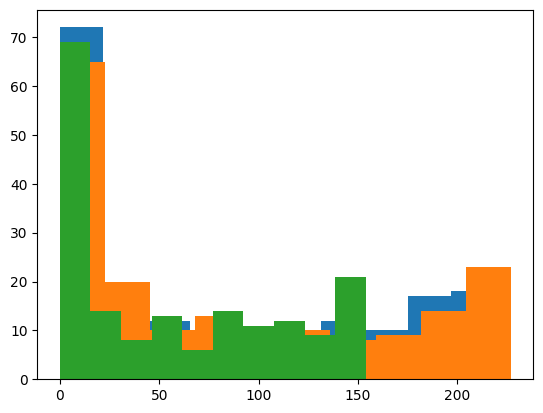

In [89]:
plt.hist(comcam_x_milliquas_computed['n_g'])
plt.hist(comcam_x_milliquas_computed['n_r'])
plt.hist(comcam_x_milliquas_computed['n_i'])

### Are the AGNs found in ComCam roughly the same brightness (in mag) as what is reported in MilliQuas?

In [23]:
ndf = comcam_x_milliquas.partitions[0].compute()

print(len(ndf))
print(ndf.columns)
print(ndf.index)

38
Index(['diaObjectId_COM', 'ra_COM', 'dec_COM', 'nDiaSources_COM',
       'radecMjdTai_COM', 'tract_COM', 'diaSource_COM',
       'diaObjectForcedSource_COM', 'RA_MIL', 'DEC_MIL', 'NAME_MIL',
       'TYPE_MIL', 'RMAG_MIL', 'BMAG_MIL', 'COMMENT_MIL', 'R_MIL', 'B_MIL',
       'Z_MIL', 'CITE_MIL', 'ZCITE_MIL', 'XNAME_MIL', 'RNAME_MIL', 'LOBE1_MIL',
       'LOBE2_MIL', '_dist_arcsec'],
      dtype='object')
Index([9583286184991586, 9589207111731798, 9605063046626456, 9612527476569840,
       9615793306942506, 9625426084695015, 9625426085853595, 9629578309504534,
       9629578330482523, 9629995726856429, 9634023935025897, 9634690526094145,
       9637593900392112, 9638975493945711, 9651991629094477, 9652264966279831,
       9652525845238071, 9652568124498163, 9658005170317152, 9679826662690117,
       9679826689822653, 9682061241281563, 9684445387689698, 9684837729269318,
       9692888493592358, 9714685688630238, 9714685690233654, 9715348208429896,
       9716929074053214, 9717229661831

In [24]:
# Absolute and relative differences in the magnitudes of the first partition

# Using the mean of the "scienceMag" from the COMCAM sources
# and the "RMAG_MIL" from the Milliquas objects

rows_to_print = 10
for i in ndf.index:
    mean_mag_COM = np.mean(ndf.loc[i, "diaSource_COM"]["scienceMag"])
    mag_MIL = ndf.loc[i, "RMAG_MIL"]
    abs_diff = np.abs(mean_mag_COM - mag_MIL)
    rel_diff = abs_diff / mag_MIL

    if rows_to_print:
        print(f"Abs: {abs_diff:>5.2}, Rel: {rel_diff:.2}")
        rows_to_print -= 1

    if rel_diff > 0.5:
        raise ValueError("Relative difference is too large")

Abs:   0.4, Rel: 0.021
Abs:  0.32, Rel: 0.017
Abs:   1.0, Rel: 0.051
Abs:  0.24, Rel: 0.012
Abs: 0.072, Rel: 0.0037
Abs:  0.64, Rel: 0.034
Abs:  0.33, Rel: 0.017
Abs:   2.1, Rel: 0.13
Abs:   2.4, Rel: 0.15
Abs: 0.074, Rel: 0.0038


## Plot lightcurves

"Depending on the numer of the objects we can discuss how to do this best."

In [ ]:
# There are 87 rows in the first partition

# This is a similar order of magnitude as "ZTF and PS1 for SNAD catalog" (link), so can reference if needed
# https://docs.lsdb.io/en/stable/tutorials/pre_executed/zubercal-ps1-snad.html

In [25]:
good_indices = []

for i in ndf.index:
    if ndf.loc[i, "nDiaSources_COM"] > 20:
        print(f"Row {i} has {ndf.loc[i, 'nDiaSources_COM']} sources")
        good_indices.append(i)

print(len(good_indices))

Row 9612527476569840 has 24 sources
Row 9625426085853595 has 22 sources
Row 9634023935025897 has 29 sources
Row 9634690526094145 has 27 sources
Row 9715348208429896 has 21 sources
Row 9785092585155222 has 38 sources
6


### Mag LCs

Referencing plots in: https://github.com/lsst-sitcom/linccf/blob/main/demo_notebooks/periodic_lightcurves.ipynb

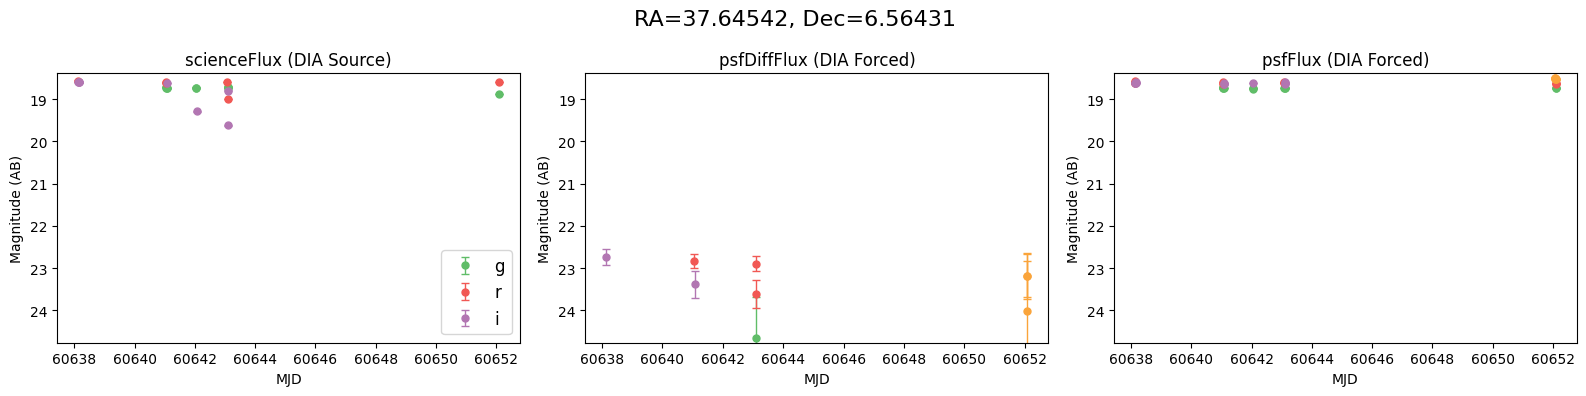

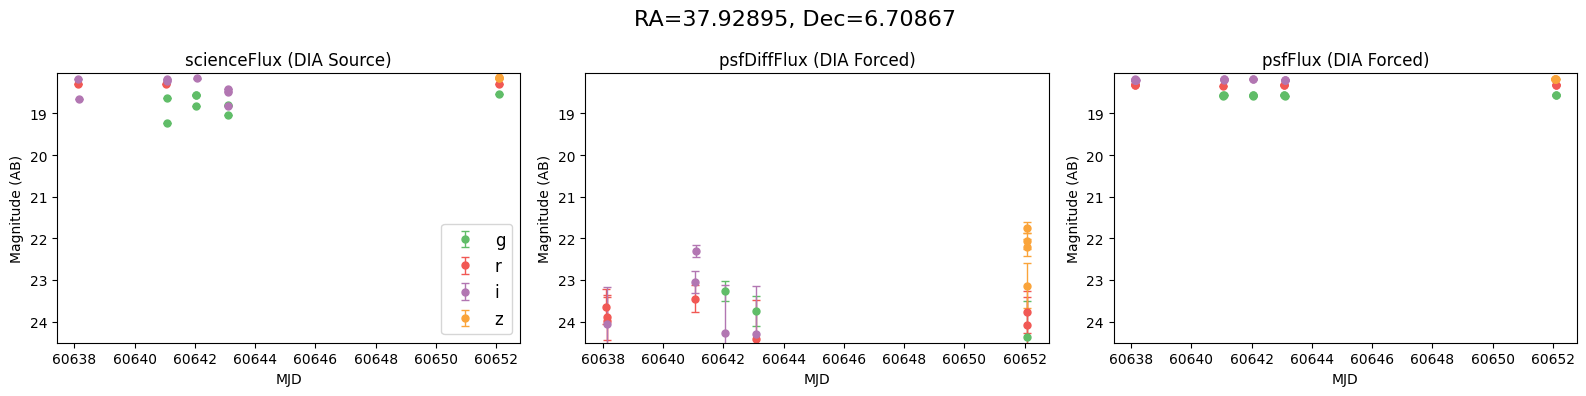

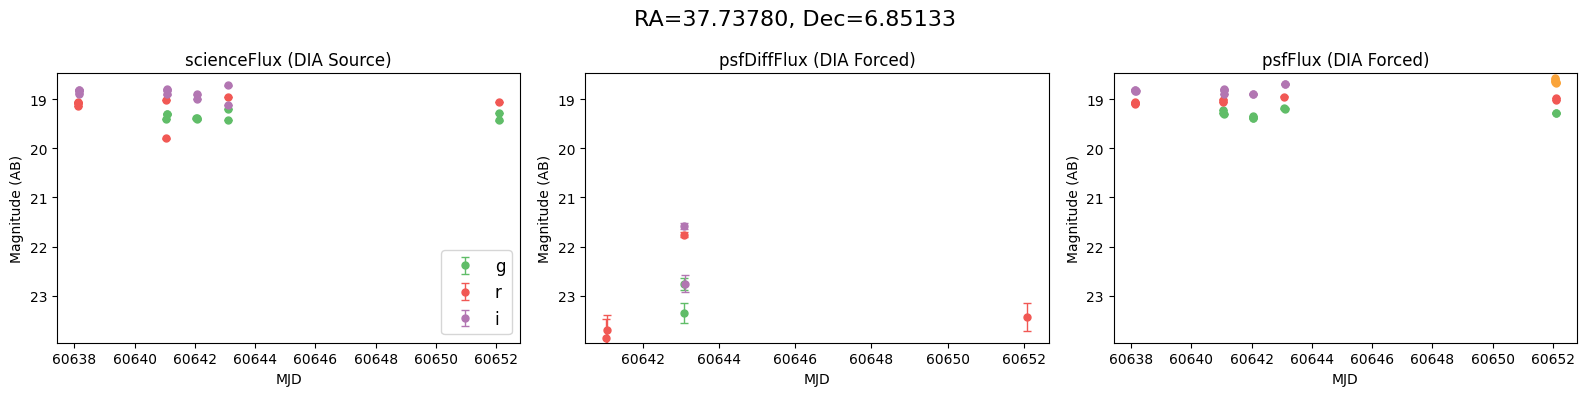

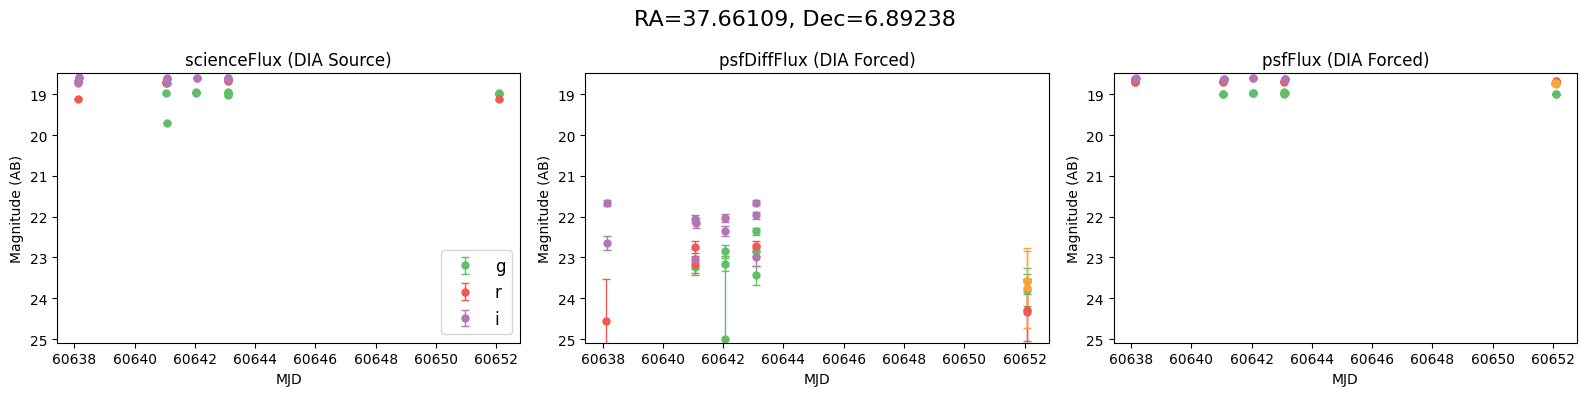

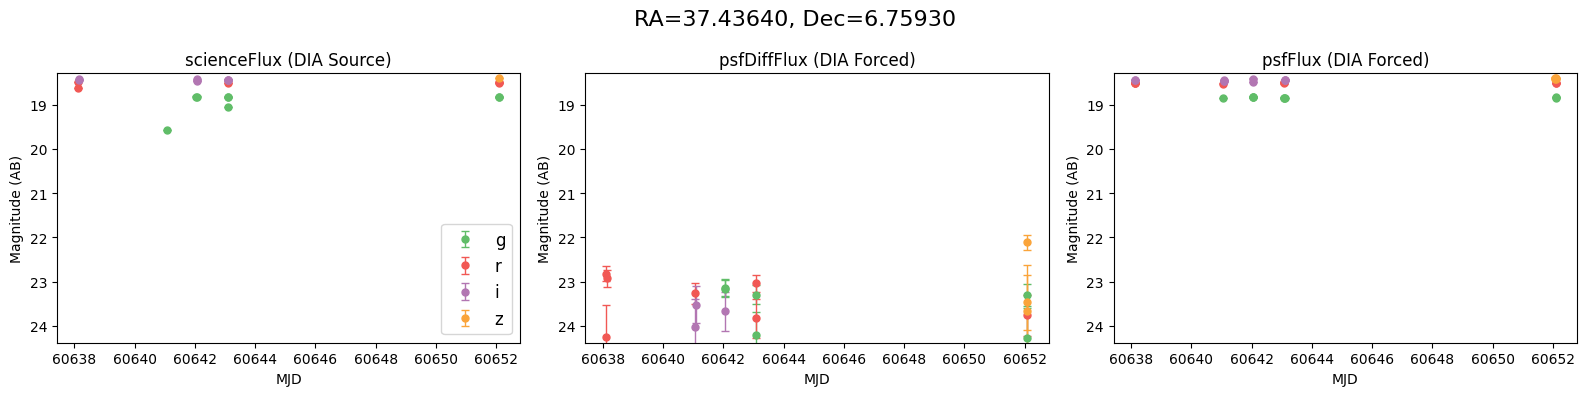

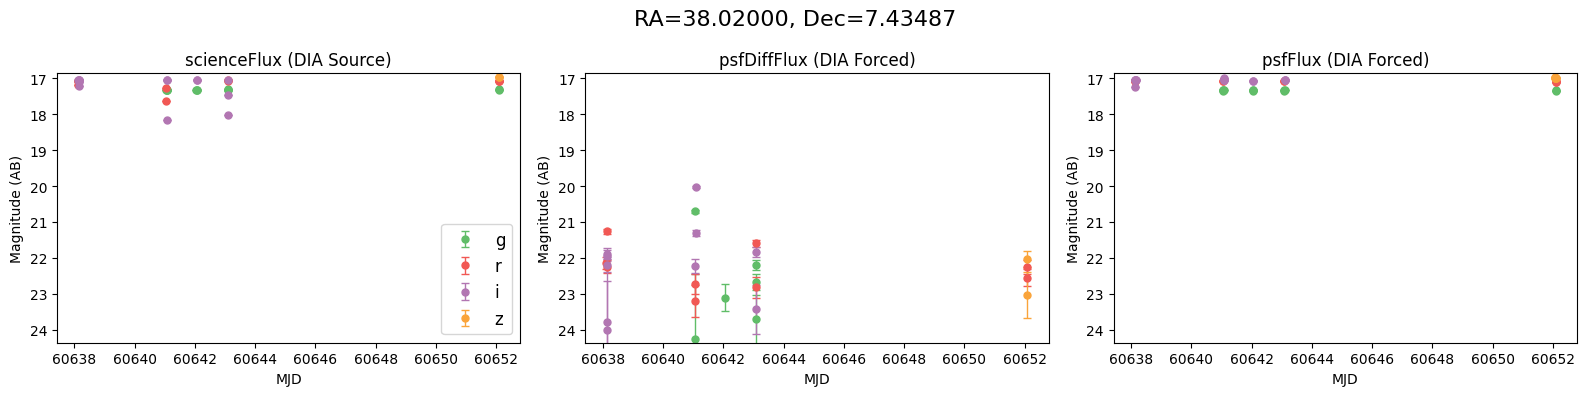

In [26]:
COLORS = {
    "u": "#5DA5DA",  # sky blue
    "g": "#60BD68",  # leafy green
    "r": "#F15854",  # warm red
    "i": "#B276B2",  # lavender/magenta
    "z": "#FAA43A",  # orange/yellow
    "y": "#4D4D4D",  # dark gray (neutral anchor)
}

def create_mag_errors(flux, flux_err):
    # Make sure everything is valid and flux ± err stays positive
    upper = flux + flux_err
    lower = flux - flux_err
    mask = (
        flux.notna()
        & flux_err.notna()
        & (flux > 0)
        & (upper > 0)
        & (lower > 0)
    )

    # Initialize with NaNs
    mag = np.full_like(flux, np.nan, dtype=float)
    mag_err = np.full_like(flux, np.nan, dtype=float)

    # Apply the AB mag conversion only to valid values
    valid_flux = flux[mask]
    valid_err = flux_err[mask]

    mag[mask] = u.nJy.to(u.ABmag, valid_flux)
    upper_mag = u.nJy.to(u.ABmag, valid_flux + valid_err)
    lower_mag = u.nJy.to(u.ABmag, valid_flux - valid_err)
    mag_err[mask] = -(upper_mag - lower_mag) / 2

    return pd.Series(mag, index=flux.index), pd.Series(mag_err, index=flux.index)

def plot_mag_scale(ax, lc, flux_col, flux_err_col, x_name, x_label, show_legend=False):
    mag_vals = []
    for band, color in COLORS.items():
        band_lc = lc.query(f"band == '{band}'")
        if band_lc.empty:
            continue
        mag, mag_err = create_mag_errors(band_lc[flux_col], band_lc[flux_err_col])
        ax.errorbar(
            band_lc[x_name],
            mag,
            mag_err,
            fmt="o",
            label=band,
            color=color,
            alpha=1,
            markersize=5,
            capsize=3,
            elinewidth=1,
        )
        mag_vals.extend(mag.dropna().values)
    ax.set_xlabel(x_label)
    ax.set_ylabel("Magnitude (AB)")
    ax.invert_yaxis()
    if show_legend:
        ax.legend(loc="lower right", fontsize=12)
    return mag_vals

def scale_mag_y_axis(ax, all_mags):
    if all_mags[0]:
        ymin, ymax = np.nanmin(all_mags[0]), np.nanmax(all_mags[0])
        for i in range(3):
            ax[0, i].set_ylim(ymax + 0.1, ymin - 0.1)

def plot_mag_lightcurves(ax, row):
    datasets = [
        ("scienceFlux", "DIA Source", row.diaSource_COM),
        ("psfDiffFlux", "DIA Forced", row.diaObjectForcedSource_COM),
        ("psfFlux", "DIA Forced", row.diaObjectForcedSource_COM),
    ]
    all_mags = [[], []]
    for i, (flux_col, label, lc) in enumerate(datasets):
        flux_err_col = f"{flux_col}Err"
        ax[0, i].set_title(f"{flux_col} ({label})")

        all_mags[0].extend(
            plot_mag_scale(ax[0, i], lc, flux_col, flux_err_col, "midpointMjdTai", "MJD", show_legend=(i == 0))
        )
    return all_mags

# Now plot
for i in good_indices:
    row = ndf.loc[i]
    fig, ax = plt.subplots(1, 3, figsize=(16, 4))  # Just one row now
    fig.suptitle(f"RA={row.ra_COM:.5f}, Dec={row.dec_COM:.5f}", fontsize=16)
    all_mags = plot_mag_lightcurves(np.expand_dims(ax, 0), row)  # Make ax 2D for consistency
    scale_mag_y_axis(np.expand_dims(ax, 0), all_mags)
    plt.tight_layout()
    plt.show()

### Flux LCs

In [ ]:
def plot_flux_scale(ax, lc, flux_col, flux_err_col, x_name, x_label, show_legend=False):
    flux_vals = []
    for band, color in COLORS.items():
        band_lc = lc.query(f"band == '{band}'")
        if band_lc.empty:
            continue
        ax.errorbar(
            band_lc[x_name],
            band_lc[flux_col],
            band_lc[flux_err_col],
            fmt="o",
            label=band,
            color=color,
            alpha=1,
            markersize=5,
            capsize=3,
            elinewidth=1,
        )
        flux_vals.extend(band_lc[flux_col].dropna().values)
    ax.set_xlabel(x_label)
    ax.set_ylabel(f"{flux_col} (nJy)")
    if show_legend:
        ax.legend(loc="upper right", fontsize=12)
    return flux_vals

def scale_flux_y_axis(ax, all_flux):
    if all_flux[0]:
        ymin, ymax = np.nanmin(all_flux[0]), np.nanmax(all_flux[0])
        for i in range(3):
            ax[0, i].set_ylim(ymin - 0.1 * abs(ymin), ymax + 0.1 * abs(ymax))

def plot_flux_lightcurves(ax, row):
    datasets = [
        ("scienceFlux", "DIA Source", row.diaSource_COM),
        ("psfDiffFlux", "DIA Forced", row.diaObjectForcedSource_COM),
        ("psfFlux", "DIA Forced", row.diaObjectForcedSource_COM),
    ]
    all_flux = [[]]
    for i, (flux_col, label, lc) in enumerate(datasets):
        flux_err_col = f"{flux_col}Err"
        ax[0, i].set_title(f"{flux_col} ({label})")

        all_flux[0].extend(
            plot_flux_scale(ax[0, i], lc, flux_col, flux_err_col, "midpointMjdTai", "MJD", show_legend=(i == 0))
        )
    return all_flux

for i in good_indices:
    row = ndf.loc[i]
    fig, ax = plt.subplots(1, 3, figsize=(16, 4))
    fig.suptitle(f"RA={row.ra_COM:.5f}, Dec={row.dec_COM:.5f}", fontsize=16)
    all_flux = plot_flux_lightcurves(np.expand_dims(ax, 0), row)
    scale_flux_y_axis(np.expand_dims(ax, 0), all_flux)
    plt.tight_layout()
    plt.show()


In [ ]:
# Flux error bars--there, just small

row = ndf.loc[good_indices[0]]
row.diaObjectForcedSource_COM[["psfFlux", "psfFluxErr"]].describe()

## Plot structure function

Referencing: https://github.com/rubin-dp0/delegate-contributions-dp02/blob/main/variable_stars/var_stars_sf.ipynb

In [ ]:
from numba import njit

@njit
def calcSF(taumin, taumax, tclip, fclip, nstep):
    dtau = (np.log10(taumax) - np.log10(taumin)) / nstep

    tau1 = np.zeros(nstep)
    tau2 = np.zeros(nstep)
    N = np.zeros(nstep)
    SF = np.zeros(nstep)

    for k in range(nstep):
        tau1[k] = 10**(np.log10(taumin) + k*dtau)
        tau2[k] = 10**(np.log10(tau1[k]) + dtau)
        for i in range(tclip.size):
            dist = tclip[i:] - tclip[i]
            sel = (dist >= tau1[k]) & (dist < tau2[k])
            N[k] += tclip[i:][sel].size
            if tclip[i:][sel].size > 0:
                SF[k] += np.sum((fclip[i:][sel] - fclip[i])**2)
        SF[k] = np.sqrt(SF[k] / N[k]) if N[k] > 0 else np.nan

    return tau1, tau2, SF, N


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def SF_analysis(df, nstep=50, Nmin=2):
    objects = df['Object_ID'].unique()

    for obj in objects:
        obj_data_all = df[df['Object_ID'] == obj]

        fig_sf, ax_sf = plt.subplots(figsize=(7, 3))
        ax_sf.set_title(f"Structure Function: {obj}")

        for filt in sorted(df['Filter'].unique()):
            filt_data = obj_data_all[obj_data_all['Filter'] == filt].drop_duplicates(subset='Epoch')
            if filt_data.empty:
                continue

            filt_data = filt_data.sort_values(by='Epoch')
            mag = filt_data['Mag']

            # Iterative 5σ clipping
            count_old = len(mag) + 1
            count = len(mag)
            excluded = [[], []]

            while count_old > count:
                mag_mean = mag.mean()
                mag_std = mag.std(ddof=1)
                outliers = np.abs(mag - mag_mean) >= 5 * mag_std
                excluded[0] += filt_data['Epoch'][outliers].to_list()
                excluded[1] += mag[outliers].to_list()
                filt_data = filt_data[~outliers]
                mag = filt_data['Mag']
                count_old = count
                count = len(mag)

            if filt_data.empty:
                continue

            # Convert mag → normalized flux
            flux = 10**(-0.4 * (mag - np.median(mag)))
            time = filt_data['Epoch'].to_numpy()

            # SF time limits
            dtmin = np.min(np.diff(time))
            dtmax = time[-1] - time[0]
            taumin = 2 * dtmin
            taumax = 0.5 * dtmax

            tau1, tau2, SF, N = calcSF(taumin, taumax, time, flux.to_numpy(), nstep)

            ax_sf.loglog(tau1[N > Nmin], SF[N > Nmin], label=filt, marker="o", linestyle="")

        ax_sf.set_xlabel("Time lag (days)")
        ax_sf.set_ylabel("Structure Function")
        ax_sf.grid(True)
        ax_sf.legend()
        plt.show()


In [ ]:
def make_long_df(catalog):
    rows = []
    for _, row in catalog.iterrows():
        obj_id = row.diaObjectId_COM
        for table in ['diaSource_COM', 'diaObjectForcedSource_COM']:
            lc = row[table]
            if lc.empty:
                continue
            for _, lc_row in lc.iterrows():
                if lc_row['psfFlux'] > 0 and not lc_row['psfFlux_flag']:
                    flux = lc_row['psfFlux']
                    flux_err = lc_row['psfFluxErr']
                    mag = -2.5 * np.log10(flux / 3631e9)  # Convert nJy to AB mag
                    rows.append({
                        'Object_ID': obj_id,
                        'Filter': lc_row['band'],
                        'Epoch': lc_row['midpointMjdTai'],
                        'psfFlux': flux,
                        'psfFluxErr': flux_err,
                        'Mag': mag,
                    })
    return pd.DataFrame(rows)

In [ ]:
good_df = ndf.loc[good_indices]
lc_long_df = make_long_df(good_df)
SF_analysis(lc_long_df)

### All on the same plot

In [ ]:
def SF_compare_plot(df, nstep=50, Nmin=2, legend=True):
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.set_title("Structure Functions (All Objects)")
    
    for obj in df['Object_ID'].unique():
        obj_data_all = df[df['Object_ID'] == obj]

        for filt in sorted(df['Filter'].unique()):
            filt_data = obj_data_all[obj_data_all['Filter'] == filt].drop_duplicates(subset='Epoch')
            if filt_data.empty:
                continue

            filt_data = filt_data.sort_values(by='Epoch')
            mag = filt_data['Mag']
            count_old = len(mag) + 1
            count = len(mag)
            while count_old > count:
                mag_mean = mag.mean()
                mag_std = mag.std(ddof=1)
                filt_data = filt_data[np.abs(mag - mag_mean) < 5 * mag_std]
                mag = filt_data['Mag']
                count_old = count
                count = len(mag)

            if filt_data.empty:
                continue

            flux = 10**(-0.4 * (mag - np.median(mag)))
            time = filt_data['Epoch'].to_numpy()
            dtmin = np.min(np.diff(time))
            dtmax = time[-1] - time[0]
            taumin = 2 * dtmin
            taumax = 0.5 * dtmax

            tau1, tau2, SF, N = calcSF(taumin, taumax, time, flux.to_numpy(), nstep)
            
            label = f"{obj} ({filt})"
            ax.loglog(tau1[N > Nmin], SF[N > Nmin], label=label, marker="o", linestyle="")

    ax.set_xlabel("Time lag (days)")
    ax.set_ylabel("Structure Function")
    ax.grid(True)
    if legend:
        ax.legend()
    plt.show()


In [ ]:
SF_compare_plot(lc_long_df)

### Adjust cut from >20 to >10 sources

In [ ]:
good_indices_cut_at_10 = []

for i in ndf.index:
    if ndf.loc[i, "nDiaSources_COM"] > 10:
        print(f"Row {i} has {ndf.loc[i, 'nDiaSources_COM']} sources")
        good_indices_cut_at_10.append(i)

print(len(good_indices_cut_at_10))

In [ ]:
good_df_cut_at_10 = ndf.loc[good_indices_cut_at_10]
lc_long_df_cut_at_10 = make_long_df(good_df_cut_at_10)
SF_compare_plot(lc_long_df_cut_at_10, legend=False)